# Problem Statement

Life expectancy is a key indicator of a population's overall health and well-being, reflecting the cumulative impact of social, economic, and healthcare factors. Understanding what drives differences in life expectancy across countries is crucial for policymakers aiming to improve public health and reduce inequalities. In Europe, countries exhibit notable variation in life expectancy, which may be influenced by economic conditions, income distribution, and social deprivation.

This project investigates which economic metrics are the best predictors of life expectancy among European Union countries. Specifically, we analyze the relationship between life expectancy at birth and several economic and social indicators, including real GDP per capita, income inequality (measured by the difference and ratio between mean and median income), material deprivation rates, and the proportion of people living in low work intensity households. By identifying the most influential predictors, we aim to provide insights into how economic policies and social conditions can impact population health outcomes.

This topic is important because it addresses the intersection of economics and public health, offering evidence that can inform targeted interventions to improve life expectancy and reduce disparities across Europe.

# Data Description

The dataset used in this project consists of several harmonized indicators collected for European Union (EU) countries from 2004 to 2023. The data was sourced from Eurostat, the statistical office of the European Union, and includes the following components:

- **Life Expectancy at Birth**: Annual country-level data on life expectancy for newborns, disaggregated by sex.  
  *Source: Eurostat, `estat_demo_mlexpec_en.csv`*

- **Material Deprivation Rate**: Percentage of people experiencing material deprivation, reflecting economic hardship.  
  *Source: Eurostat, `estat_ilc_mdsd04_filtered_en.csv`*

- **Income Data**: Mean and median equivalized disposable income, measured in Purchasing Power Standard (PPS) to allow cross-country comparability.  
  *Source: Eurostat, `estat_ilc_di15_filtered_en.csv`*

- **Low Work Intensity Households**: Proportion of people living in households with very low work intensity.  
  *Source: Eurostat, `estat_ilc_lvhl16n_filtered_en.csv`*

- **Real GDP per Capita**: Real gross domestic product per capita, adjusted for inflation and expressed in PPS.  
  *Source: Eurostat, `estat_tipsna40_en.csv`*

- **Population Data**: Population counts by age group and sex, used for weighting income statistics.  
  *Source: Eurostat, `estat_demo_pjanbroad_filtered_en.csv`*

All datasets were filtered to include only EU member states and the relevant years. The data was further processed to ensure consistency across indicators, and only the age group "less than one year" was used for life expectancy to focus on life expectancy at birth. Income data was aggregated using population weights to obtain representative national values. All sources are publicly available from [Eurostat](https://ec.europa.eu/eurostat).

### Importing necessary libraries:

In [55]:
import pandas as pd 
import os 
import pymc as pm 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import arviz as az
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Data preprocessing

### Load the data and put them into data dictionary 

In [56]:
# Data path
data_path = os.path.join(os.getcwd(), '..', 'Data')

# Load the data
life_expectancy = pd.read_csv(os.path.join(data_path, 'estat_demo_mlexpec_en.csv'))
material_deprivation_rate = pd.read_csv(os.path.join(data_path, 'estat_ilc_mdsd04_filtered_en.csv'))
median_and_mean_group_income = pd.read_csv(os.path.join(data_path, 'estat_ilc_di15_filtered_en.csv'))
low_work_intensity_households = pd.read_csv(os.path.join(data_path, 'estat_ilc_lvhl16n_filtered_en.csv'))
real_gdp = pd.read_csv(os.path.join(data_path, 'estat_tipsna40_en.csv'))
population_data = pd.read_csv(os.path.join(data_path, 'estat_demo_pjanbroad_filtered_en.csv'))


# Dataframes dictionary 
dataframes_dict = {
    'life_expectancy': life_expectancy,
    'material_deprivation_rate': material_deprivation_rate,
    'median_and_mean_group_income': median_and_mean_group_income,
    'low_work_intensity_households': low_work_intensity_households,
    'real_gdp': real_gdp,
    'population_data': population_data
}


### Include only EU data and set data collection window to 2004 - 2023
GDP data is not older than 2003, therefore we use a data collection window of 2004 - 2023. For some datasets we don't have data from 2024.

In [57]:
# Include only EU data and set data collection window
eu_countries = ['Austria', 'Belgium', 'Bulgaria', 'Cyprus', 'Czechia', 'Germany',
       'Denmark','Estonia',
       'Greece', 'Spain', 'Finland', 'France', 'Croatia', 'Hungary', 'Ireland', 'Italy',
       'Lithuania', 'Luxembourg', 'Latvia', 'Malta', 'Netherlands',
       'Poland', 'Portugal', 'Romania', 'Sweden', 'Slovenia', 'Slovakia']

for key, df in dataframes_dict.items():
    dataframes_dict[key] = df[df['Geopolitical entity (reporting)'].isin(eu_countries)].reset_index(drop=True)
for key, df in dataframes_dict.items():
    dataframes_dict[key] = df.loc[(df['TIME_PERIOD'] >= 2004) & (df['TIME_PERIOD'] < 2024)].reset_index(drop=True)


### Filter data for "Less than one year" age group
This data represents the average life expectancy.

In [58]:
# Filter life expectancies for newborns
dataframes_dict['life_expectancy'] = dataframes_dict['life_expectancy'].loc[dataframes_dict['life_expectancy']['age'] == 'Y_LT1'].reset_index(drop=True)

# Filter PPS currency
Median and mean data are available in three formats Euro, regional currency and PPS (Purchasing Power Standrad), we decide to use PPS because it adjusts for price level differences across regions, providing a more accurate basis for cross-country comparisons.

In [59]:
# Filter PPS (Purchasing Power Standard) currency 
dataframes_dict['median_and_mean_group_income'] = dataframes_dict['median_and_mean_group_income'].loc[dataframes_dict['median_and_mean_group_income']['unit'] == 'PPS'].reset_index(drop=True)


### Generalize mean and median data 
Since mean and median values in our dataset are segmented by age groups, we gather corresponding population data and compute weighted averages. This allows us to estimate overall population-level statistics for our analysis. We also remove unnecessary columns. 

In [60]:
# Generalize mean and median data
# Filter age groups present in the data
age_groups = ['From 18 to 64 years', '65 years or over']
dataframes_dict['median_and_mean_group_income'] = dataframes_dict['median_and_mean_group_income'][dataframes_dict['median_and_mean_group_income']['Age class'].isin(age_groups)].reset_index(drop=True)

# Remove unnecessary columns
for key, df in dataframes_dict.items():
    dataframes_dict[key] = df.drop(columns=['STRUCTURE', 'STRUCTURE_NAME', 'STRUCTURE_ID', 'Confidentiality status (flag)', 'CONF_STATUS', 'Observation status (Flag) V2 structure', 'unit', 'Observation value', 'Time', 'geo', 'age', 'Sex',
                                            'Country of citizenship', 'citizen', 'Unit of measure', 'Income and living conditions indicator', 'freq', 'Time frequency', 'OBS_FLAG', 'National accounts indicator (ESA 2010)', 'na_item', 'c_birth', 'Country/region of birth'], errors='ignore')
    
    # Because the income date is available only by population, we need to merge it with population data to be able to combine the date for the whole population
dataframes_dict['population_data'].rename(columns={'OBS_VALUE': 'population'}, inplace=True)
dataframes_dict['population_data'].replace({'Age class': {'From 15 to 64 years': 'From 18 to 64 years'}}, inplace=True)
dataframes_dict['population_data'] = dataframes_dict['population_data'].loc[dataframes_dict['population_data']['Age class'] != 'Less than 15 years'].reset_index(drop=True)

dataframes_dict['median_and_mean_group_income'] = pd.merge(dataframes_dict['median_and_mean_group_income'],
                  dataframes_dict['population_data'],
                  on=['sex','Geopolitical entity (reporting)', 'TIME_PERIOD', 'Age class'],
                  how='left') 

# We group the data to calculate the weighted average of OBS_VALUE by population for each group defined
group_cols = ['sex', 'Geopolitical entity (reporting)', 'TIME_PERIOD', 'indic_il']

def weighted_average(group_df):
    weighted_sum = (group_df['OBS_VALUE'] * group_df['population']).sum()
    total_population = group_df['population'].sum()
    
    if total_population > 0:
        weighted_avg = weighted_sum / total_population
    else:
        weighted_avg = 0 
    
    return pd.Series({
        'OBS_VALUE': weighted_avg
    })

# Transform median and mean into seperate columns
dataframes_dict['median_and_mean_group_income'] = dataframes_dict['median_and_mean_group_income'].groupby(group_cols).apply(weighted_average).reset_index()
dataframes_dict['life_expectancy'] = dataframes_dict['life_expectancy'].drop(columns='Age class')
dataframes_dict['material_deprivation_rate'] = dataframes_dict['material_deprivation_rate'].drop(columns='Age class')
dataframes_dict['low_work_intensity_households'] = dataframes_dict['low_work_intensity_households'].drop(columns='Age class')

dataframes_dict['median_and_mean_group_income']['indic_il']
dataframes_dict['median_and_mean_group_income'] = dataframes_dict['median_and_mean_group_income'].pivot(index=[col for col in dataframes_dict['median_and_mean_group_income'].columns if col not in ['indic_il', 'OBS_VALUE']], columns='indic_il', values='OBS_VALUE').reset_index()


/var/folders/y4/lhggv2xd4_g7wl5ry_nch6q40000gn/T/ipykernel_43040/313758494.py:38: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dataframes_dict['median_and_mean_group_income'] = dataframes_dict['median_and_mean_group_income'].groupby(group_cols).apply(weighted_average).reset_index()


# Rename columns

In [61]:
# Rename columns 
dataframes_dict['real_gdp'] = dataframes_dict['real_gdp'].rename(columns={'OBS_VALUE': 'real_gdp'})
dataframes_dict['low_work_intensity_households'] = dataframes_dict['low_work_intensity_households'].rename(columns={'OBS_VALUE': 'people_in_low_work_intensity_household_perc'})
dataframes_dict['material_deprivation_rate'] = dataframes_dict['material_deprivation_rate'].rename(columns={'OBS_VALUE': 'material_deprivation_rate_perc'})

### Create columns for GDP, mean and median 5 and 10 years later
We limit the TIME_PERIOD column to values from 2014 to 2023. However, we retain earlier data to compute additional columns for GDP, mean, and median income from 5 and 10 years prior. Data on material and social deprivation rates, as well as the share of people living in low work intensity households, is only available from 2014 onward and is used as-is.

In [62]:
# Limit life expectancy to 2014 
dataframes_dict['life_expectancy'] = dataframes_dict['life_expectancy'].loc[dataframes_dict['life_expectancy']['TIME_PERIOD'] >= 2014].reset_index(drop=True)

# Merge gdp with median and mean
real_gdp_med_mean = pd.merge(dataframes_dict['real_gdp'], dataframes_dict['median_and_mean_group_income'], on=['Geopolitical entity (reporting)', 'TIME_PERIOD'])

# Prepare GDP data for merging by creating shifted year columns
real_gdp_med_mean['TIME_PERIOD_plus_5'] = real_gdp_med_mean['TIME_PERIOD'] + 5
real_gdp_med_mean['TIME_PERIOD_plus_10'] = real_gdp_med_mean['TIME_PERIOD'] + 10

# Merge life expectancy with current year GDP
df_merged = pd.merge(dataframes_dict['life_expectancy'], real_gdp_med_mean[['Geopolitical entity (reporting)', 'TIME_PERIOD', 'real_gdp', 'MED_E', 'MEI_E', 'sex']], how='left', left_on=['Geopolitical entity (reporting)', 'TIME_PERIOD', 'sex'], right_on=['Geopolitical entity (reporting)', 'TIME_PERIOD', 'sex'])
df_merged.rename(columns={'real_gdp': 'real_gdp_current', 'MED_E': 'MED_E_current', 'MEI_E': 'MEI_E_current'}, inplace=True)

# Merge life expectancy with GDP from 5 years before
df_merged = pd.merge(df_merged, real_gdp_med_mean[['Geopolitical entity (reporting)', 'TIME_PERIOD_plus_5', 'real_gdp', 'MED_E', 'MEI_E', 'sex']], how='left', left_on=['Geopolitical entity (reporting)', 'TIME_PERIOD', 'sex'], right_on=['Geopolitical entity (reporting)', 'TIME_PERIOD_plus_5', 'sex'])
df_merged.rename(columns={'real_gdp': 'real_gdp_minus_5', 'MED_E': 'MED_E_minus_5', 'MEI_E': 'MEI_E_minus_5'}, inplace=True)

# Merge life expectancy with GDP from 10 years before
df_merged = pd.merge(df_merged, real_gdp_med_mean[['Geopolitical entity (reporting)', 'TIME_PERIOD_plus_10', 'real_gdp', 'MED_E', 'MEI_E', 'sex']], how='left', left_on=['Geopolitical entity (reporting)', 'TIME_PERIOD', 'sex'], right_on=['Geopolitical entity (reporting)', 'TIME_PERIOD_plus_10', 'sex'])
df_merged.rename(columns={'real_gdp': 'real_gdp_minus_10', 'MED_E': 'MED_E_minus_10', 'MEI_E': 'MEI_E_minus_10'}, inplace=True)

# Cleanup unnecessary columns
df_merged.drop(columns=['TIME_PERIOD_plus_5', 'TIME_PERIOD_plus_10'], inplace=True)



### Merge material and social deprivation rate, and percentage of people living in low workload households

In [63]:
df_full = pd.merge(df_merged, dataframes_dict['low_work_intensity_households'], on=['TIME_PERIOD', 'sex', 'Geopolitical entity (reporting)'])
df_full = pd.merge(df_full, dataframes_dict['material_deprivation_rate'], on=['sex', 'TIME_PERIOD', 'Geopolitical entity (reporting)'])
df_full.head()

sex Geopolitical entity (reporting)  TIME_PERIOD  OBS_VALUE  \
0   F                         Austria         2015       83.7   
1   F                         Austria         2016       84.1   
2   F                         Austria         2017       84.0   
3   F                         Austria         2018       84.1   
4   F                         Austria         2019       84.2   

   real_gdp_current  MED_E_current  MEI_E_current  real_gdp_minus_5  \
0             39640   23263.169051   25342.505855           38800.0   
1             39970   24605.250521   26527.179513           39800.0   
2             40620   24844.221020   27311.593112           39870.0   
3             41430   24443.071028   26600.126648           39540.0   
4             41970   25082.305739   27650.039982           39520.0   

   MED_E_minus_5  MEI_E_minus_5  real_gdp_minus_10  MED_E_minus_10  \
0   20206.403705   22544.439063            36950.0    17601.980989   
1   21228.830471   23461.591105            37970.0    17802.543685   
2   21636.216198   23801.369122            39270.0    18416.722715   
3   21898.770604   24150.041558            39710.0    19541.957659   
4   23041.372948   25606.672200            38200.0    20036.049266   

   MEI_E_minus_10  people_in_low_work_intensity_household_perc  \
0    19614.340744                                          4.4   
1    19607.809630                                          5.3   
2    20309.654523                                          4.9   
3    21731.722816                                          4.7   
4    22141.737160                                          4.7   

   material_deprivation_rate_perc  
0                             5.9  
1                             4.9  
2                             5.0  
3                             4.2  
4                             4.5

### Add mean and median difference, and relative difference

In [64]:
df_full['mean-median'] = df_full['MEI_E_current'] - df_full['MED_E_current']
df_full['qoutient'] = (df_full['MEI_E_current'] - df_full['MED_E_current']) / df_full['MED_E_current']
df_full = df_full.dropna()


### Split data by sex

In [65]:
women = df_full.loc[df_full['sex'] == 'F'].reset_index(drop=True)
men = df_full.loc[df_full['sex'] == 'M'].reset_index(drop=True)
total = df_full.loc[df_full['sex'] == 'T'].reset_index(drop=True)


### Plot life expectancy over time by sex

/var/folders/y4/lhggv2xd4_g7wl5ry_nch6q40000gn/T/ipykernel_43040/2441138722.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_cleaned, x='year', y='life_expectancy', hue='sex', estimator='mean', ci=None)


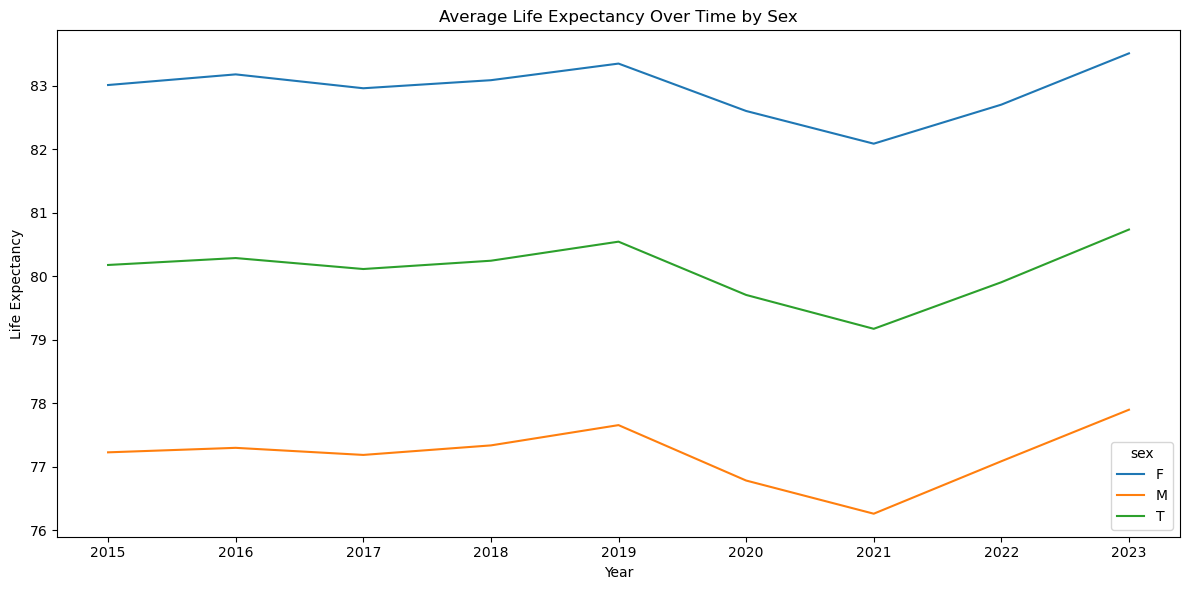

In [66]:
# Rename columns for easier plotting
df_cleaned = df_full.rename(columns={
    'Geopolitical entity (reporting)': 'country',
    'sex': 'sex',
    'TIME_PERIOD': 'year',
    'OBS_VALUE': 'life_expectancy'
})

# Plot: Life expectancy over time by sex
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_cleaned, x='year', y='life_expectancy', hue='sex', estimator='mean', ci=None)
plt.title("Average Life Expectancy Over Time by Sex")
plt.ylabel("Life Expectancy")
plt.xlabel("Year")
plt.tight_layout()
plt.show()


### Compute correlation matrices

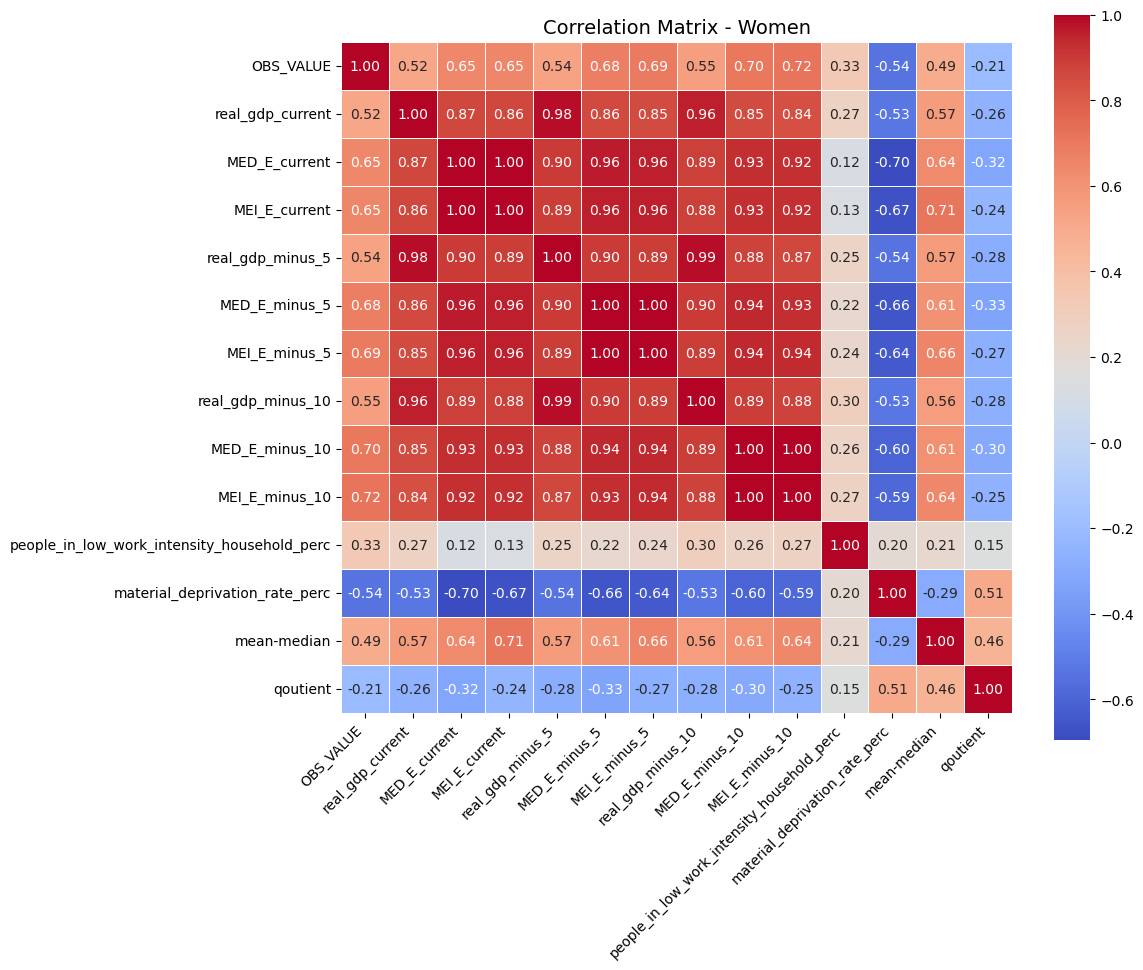

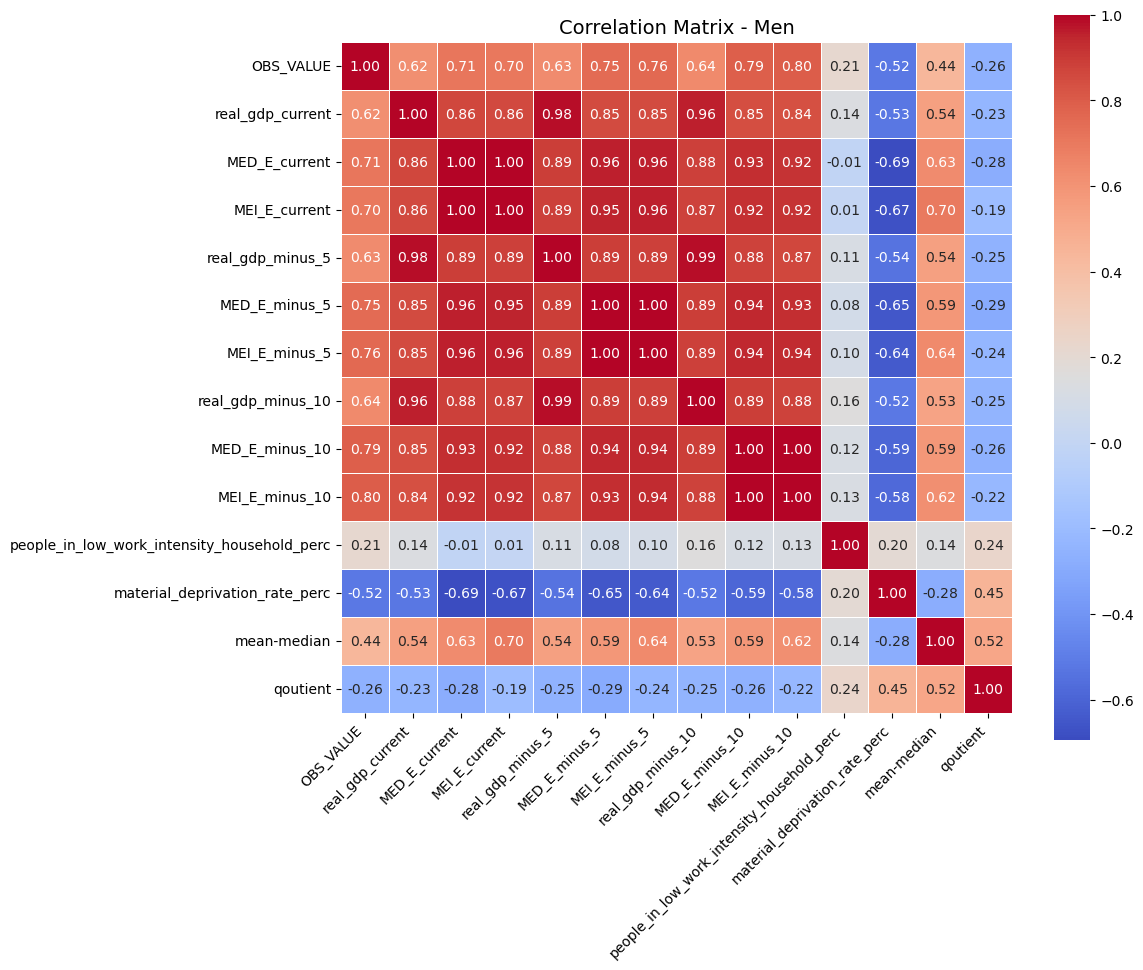

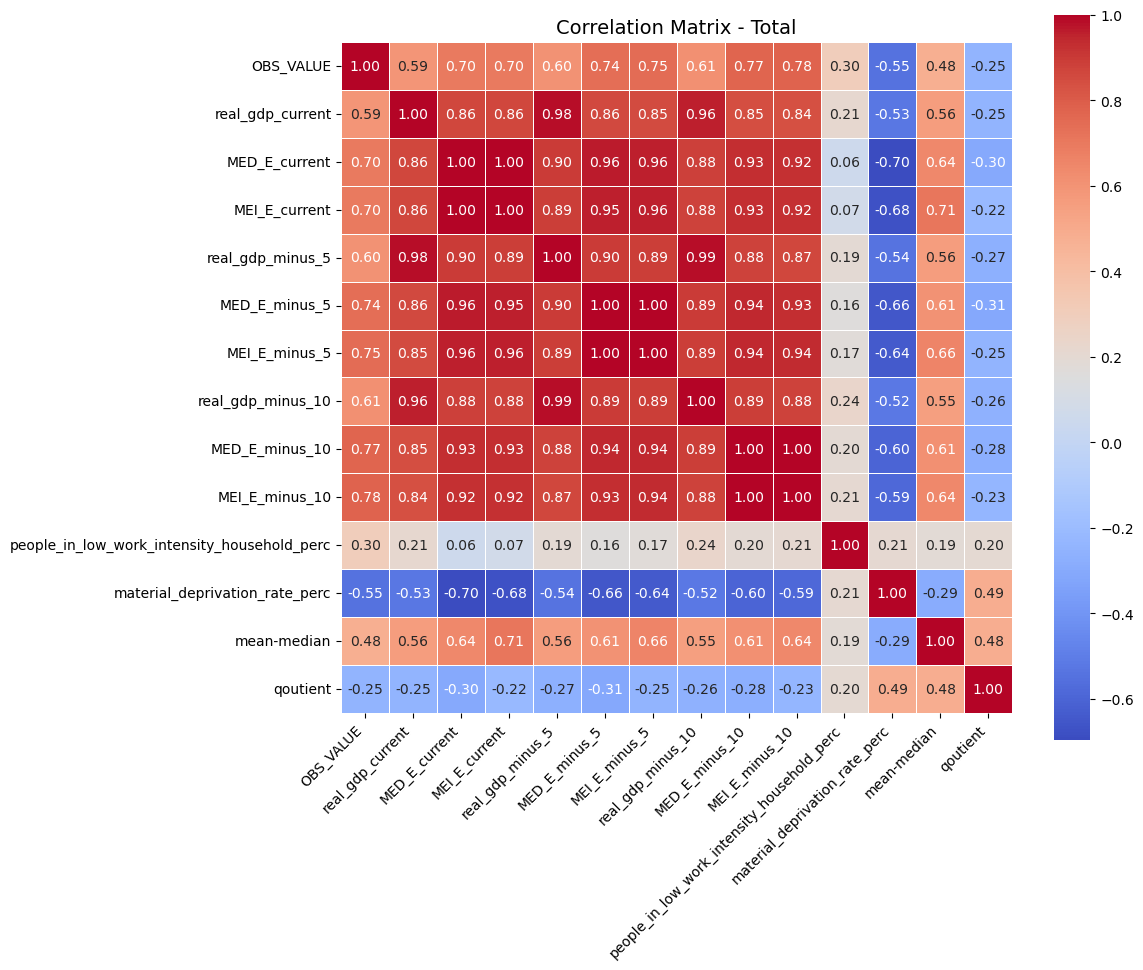

In [67]:
# Assuming 'df_full' already has the necessary columns created:
df_full['mean-median'] = df_full['MEI_E_current'] - df_full['MED_E_current']
df_full['qoutient'] = (df_full['MEI_E_current'] - df_full['MED_E_current']) / df_full['MED_E_current']

# Define correlation columns
corr_cols = [
    'OBS_VALUE', 'real_gdp_current', 'MED_E_current', 'MEI_E_current',
    'real_gdp_minus_5', 'MED_E_minus_5', 'MEI_E_minus_5',
    'real_gdp_minus_10', 'MED_E_minus_10', 'MEI_E_minus_10',
    'people_in_low_work_intensity_household_perc',
    'material_deprivation_rate_perc', 'mean-median', 'qoutient'
]

# Split by sex
women = df_full[df_full['sex'] == 'F'].reset_index(drop=True)
men = df_full[df_full['sex'] == 'M'].reset_index(drop=True)
total = df_full[df_full['sex'] == 'T'].reset_index(drop=True)

# Compute correlation matrices
corr_matrix_women = women[corr_cols].corr()
corr_matrix_men = men[corr_cols].corr()
corr_matrix_total = total[corr_cols].corr()

# Plotting function
def plot_corr_matrix(corr_matrix, title):
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr_matrix, 
        annot=True, 
        fmt=".2f", 
        cmap="coolwarm", 
        cbar=True, 
        square=True, 
        linewidths=0.5
    )
    plt.title(title, fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Plot each
plot_corr_matrix(corr_matrix_women, "Correlation Matrix - Women")
plot_corr_matrix(corr_matrix_men, "Correlation Matrix - Men")
plot_corr_matrix(corr_matrix_total, "Correlation Matrix - Total")


### Calculate VIF factor
We calculate VIF factor between our potential independent variables to check for multicolinearity.

In [68]:
# Assuming your DataFrame is called df
cols = [
    'real_gdp_current',
    'people_in_low_work_intensity_household_perc',
    'material_deprivation_rate_perc', 'qoutient',
]

sexes = [total, women, men]
for sex in sexes:
    # Subset the DataFrame
    X = sex[cols].copy()

    # Optional: scale data to make VIF more stable numerically
    X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns=cols)

    # Calculate VIF
    vif_data = pd.DataFrame()
    vif_data['feature'] = X_scaled.columns
    vif_data['VIF'] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]

    print(vif_data.sort_values('VIF', ascending=False))

                                       feature       VIF
2               material_deprivation_rate_perc  1.882005
0                             real_gdp_current  1.638098
3                                     qoutient  1.328289
1  people_in_low_work_intensity_household_perc  1.248829
                                       feature       VIF
2               material_deprivation_rate_perc  1.997522
0                             real_gdp_current  1.744609
3                                     qoutient  1.347629
1  people_in_low_work_intensity_household_perc  1.317811
                                       feature       VIF
2               material_deprivation_rate_perc  1.755837
0                             real_gdp_current  1.519076
3                                     qoutient  1.299054
1  people_in_low_work_intensity_household_perc  1.172229


We build seperate model for every group, total, women and men, because correlations suggests that impact of certain variables might be of different strenght depending on sex. We will include that when choosing parameters for informative models. 

### infromative and non informative for total

In [69]:
# Standardize predictors
features = ['real_gdp_current', 'qoutient', 'material_deprivation_rate_perc', 'people_in_low_work_intensity_household_perc']
X = women[features]
X_scaled = StandardScaler().fit_transform(X)

# Convert to a named dict for clarity in model
X_scaled = pd.DataFrame(X_scaled, columns=['gdp', 'quotient', 'deprivation', 'work_rate'])

# Target variable
y = women['OBS_VALUE']

# Model with informative priors
with pm.Model() as model_info:
    # Priors
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta_gdp = pm.Normal('beta_gdp', mu=1, sigma=0.5)
    beta_quotient = pm.Normal('beta_quotient', mu=-1, sigma=0.5)
    beta_deprivation = pm.Normal('beta_deprivation', mu=-1, sigma=0.5)
    beta_work_rate = pm.Normal('beta_work_rate', mu=1, sigma=0.5)
    sigma = pm.HalfNormal('sigma', sigma=10)

    # Linear model
    mu = (
        alpha
        + beta_gdp * X_scaled['gdp']
        + beta_quotient * X_scaled['quotient']
        + beta_deprivation * X_scaled['deprivation']
        + beta_work_rate * X_scaled['work_rate']
    )

    # Likelihood
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=y)

    # Sample
    trace_info = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)

# Model with non informative prior 
with pm.Model() as model_noninfo:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta_gdp = pm.Normal('beta_gdp', mu=0, sigma=10)
    beta_quotient = pm.Normal('beta_quotient', mu=0, sigma=10)
    beta_deprivation = pm.Normal('beta_deprivation', mu=0, sigma=10)
    beta_work_rate = pm.Normal('beta_work_rate', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=10)

    mu = (
        alpha
        + beta_gdp * X_scaled['gdp']
        + beta_quotient * X_scaled['quotient']
        + beta_deprivation * X_scaled['deprivation']
        + beta_work_rate * X_scaled['work_rate']
    )

    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=y)

    trace_noninfo = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_gdp, beta_quotient, beta_deprivation, beta_work_rate, sigma]


/opt/homebrew/anaconda3/envs/pymc_env/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_gdp, beta_quotient, beta_deprivation, beta_work_rate, sigma]


/opt/homebrew/anaconda3/envs/pymc_env/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


### Informative prior for total

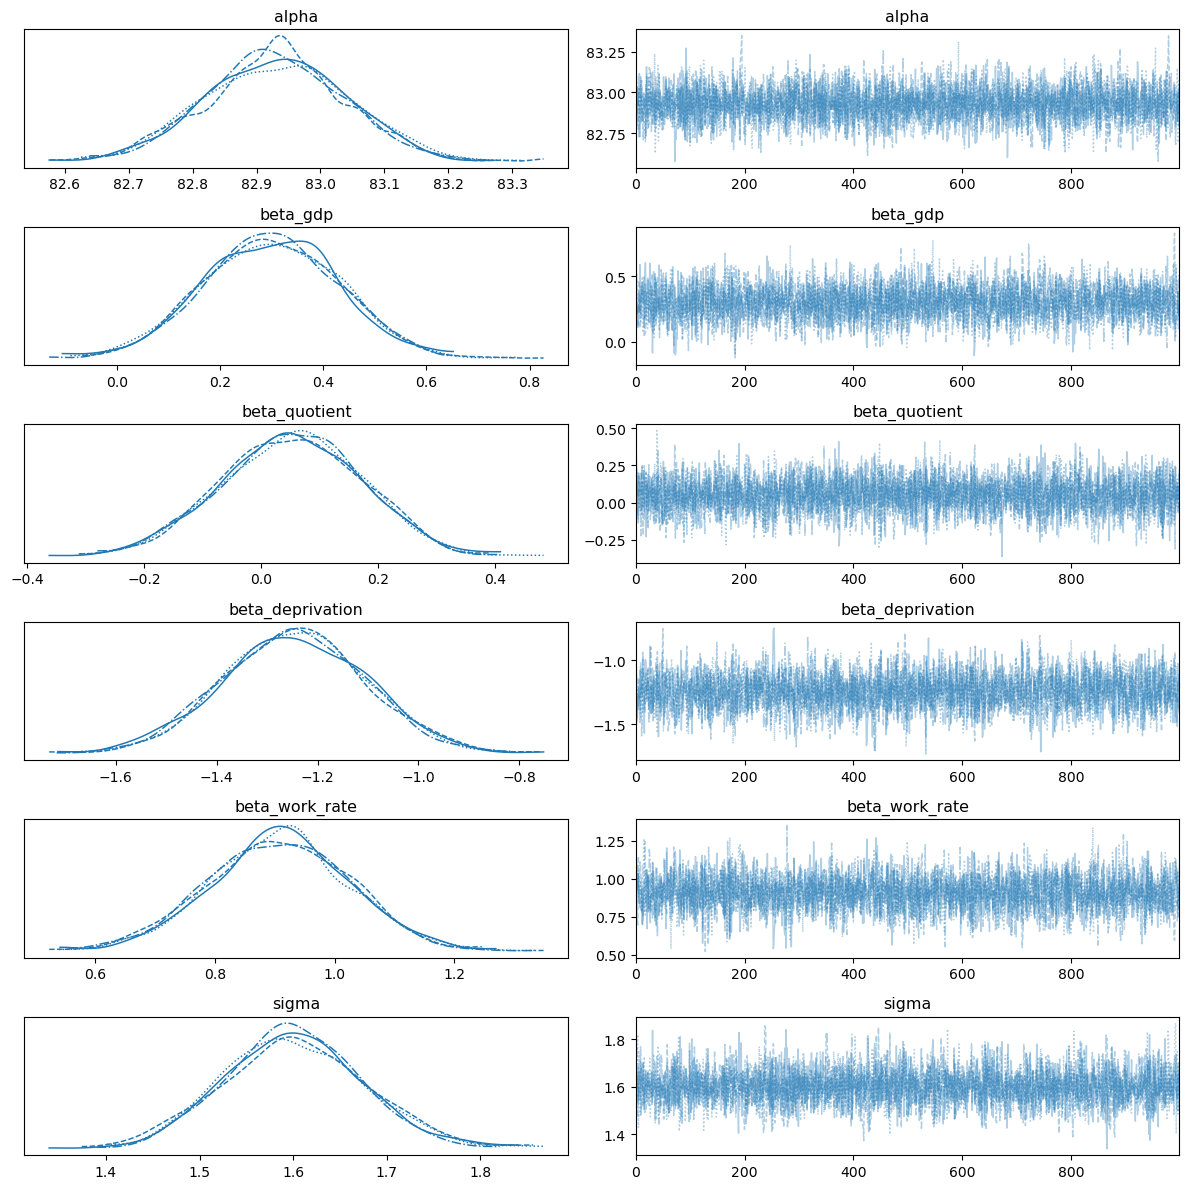

                    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
alpha             82.931  0.108  82.726   83.130      0.001    0.002   
beta_gdp           0.299  0.131   0.064    0.550      0.002    0.002   
beta_quotient      0.053  0.118  -0.158    0.275      0.002    0.002   
beta_deprivation  -1.246  0.141  -1.509   -0.985      0.002    0.002   
beta_work_rate     0.907  0.117   0.694    1.136      0.002    0.002   
sigma              1.601  0.075   1.461    1.736      0.001    0.001   

                  ess_bulk  ess_tail  r_hat  
alpha               5327.0    2429.0    1.0  
beta_gdp            3832.0    3423.0    1.0  
beta_quotient       5052.0    3084.0    1.0  
beta_deprivation    3628.0    3211.0    1.0  
beta_work_rate      4133.0    3010.0    1.0  
sigma               5038.0    2738.0    1.0  


In [70]:
# Trace plot for informative priors
az.plot_trace(trace_info, compact=True)
plt.tight_layout()
plt.show()

# Summary for informative priors 
info_summary = az.summary(trace_info)
# Pretty print with rounded decimals
print(info_summary)


# Non informative prior for total

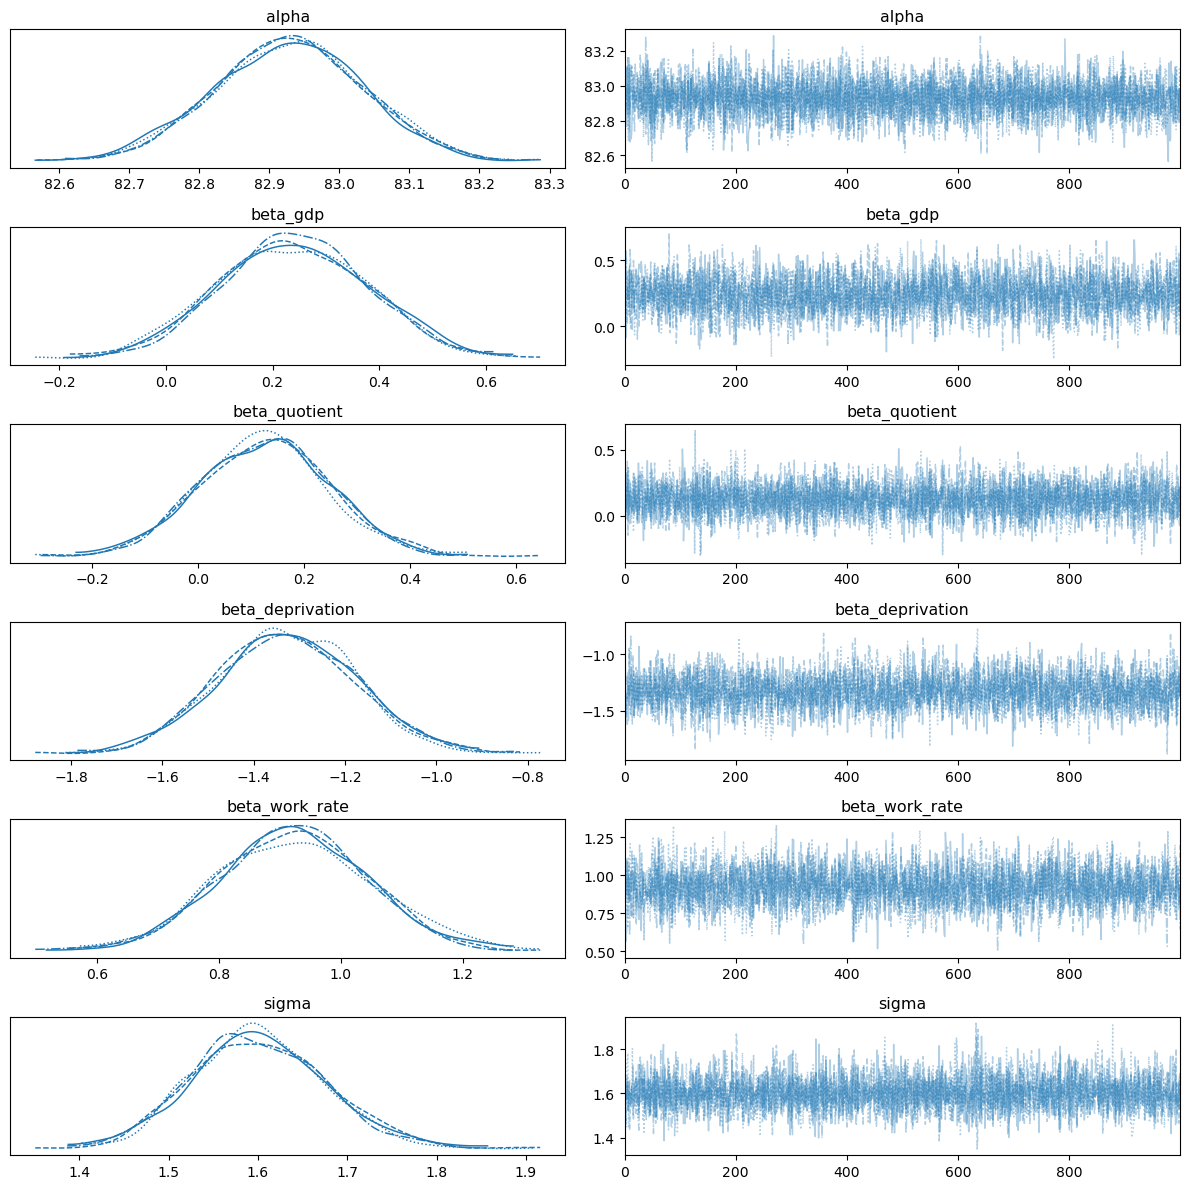

                    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
alpha             82.929  0.105  82.730   83.121      0.001    0.002   
beta_gdp           0.240  0.139  -0.017    0.498      0.002    0.002   
beta_quotient      0.125  0.121  -0.107    0.347      0.002    0.002   
beta_deprivation  -1.327  0.150  -1.610   -1.050      0.003    0.002   
beta_work_rate     0.923  0.123   0.697    1.157      0.002    0.002   
sigma              1.601  0.075   1.461    1.738      0.001    0.001   

                  ess_bulk  ess_tail  r_hat  
alpha               5332.0    2310.0    1.0  
beta_gdp            3410.0    3078.0    1.0  
beta_quotient       5001.0    3027.0    1.0  
beta_deprivation    3173.0    3022.0    1.0  
beta_work_rate      3780.0    2809.0    1.0  
sigma               4467.0    2722.0    1.0  


In [71]:
# Trace plot for non-informative priors 
az.plot_trace(trace_noninfo, compact=True)
plt.tight_layout()
plt.show()

# Summary for non-informative priors 
noninfo_summary = az.summary(trace_noninfo)
print(noninfo_summary.round(3))

### Informative and non infromative models for women

In [72]:
# Standardize predictors
features = ['real_gdp_current', 'qoutient', 'material_deprivation_rate_perc', 'people_in_low_work_intensity_household_perc']
X = women[features]
X_scaled = StandardScaler().fit_transform(X)

# Convert to a named dict for clarity in model
X_scaled = pd.DataFrame(X_scaled, columns=['gdp', 'quotient', 'deprivation', 'work_rate'])

# Target variable
y = women['OBS_VALUE']

# Model with informative priors
with pm.Model() as model_info:
    # Priors
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta_gdp = pm.Normal('beta_gdp', mu=0.5, sigma=0.5)
    beta_quotient = pm.Normal('beta_quotient', mu=-1, sigma=0.5)
    beta_deprivation = pm.Normal('beta_deprivation', mu=-1, sigma=0.5)
    beta_work_rate = pm.Normal('beta_work_rate', mu=1.5, sigma=0.5)
    sigma = pm.HalfNormal('sigma', sigma=10)

    # Linear model
    mu = (
        alpha
        + beta_gdp * X_scaled['gdp']
        + beta_quotient * X_scaled['quotient']
        + beta_deprivation * X_scaled['deprivation']
        + beta_work_rate * X_scaled['work_rate']
    )

    # Likelihood
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=y)

    # Sample
    trace_info = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)

# Model with non informative prior 
with pm.Model() as model_noninfo:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta_gdp = pm.Normal('beta_gdp', mu=0, sigma=10)
    beta_quotient = pm.Normal('beta_quotient', mu=0, sigma=10)
    beta_deprivation = pm.Normal('beta_deprivation', mu=0, sigma=10)
    beta_work_rate = pm.Normal('beta_work_rate', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=10)

    mu = (
        alpha
        + beta_gdp * X_scaled['gdp']
        + beta_quotient * X_scaled['quotient']
        + beta_deprivation * X_scaled['deprivation']
        + beta_work_rate * X_scaled['work_rate']
    )

    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=y)

    trace_noninfo = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_gdp, beta_quotient, beta_deprivation, beta_work_rate, sigma]


/opt/homebrew/anaconda3/envs/pymc_env/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_gdp, beta_quotient, beta_deprivation, beta_work_rate, sigma]


/opt/homebrew/anaconda3/envs/pymc_env/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


### Informative prior (women)

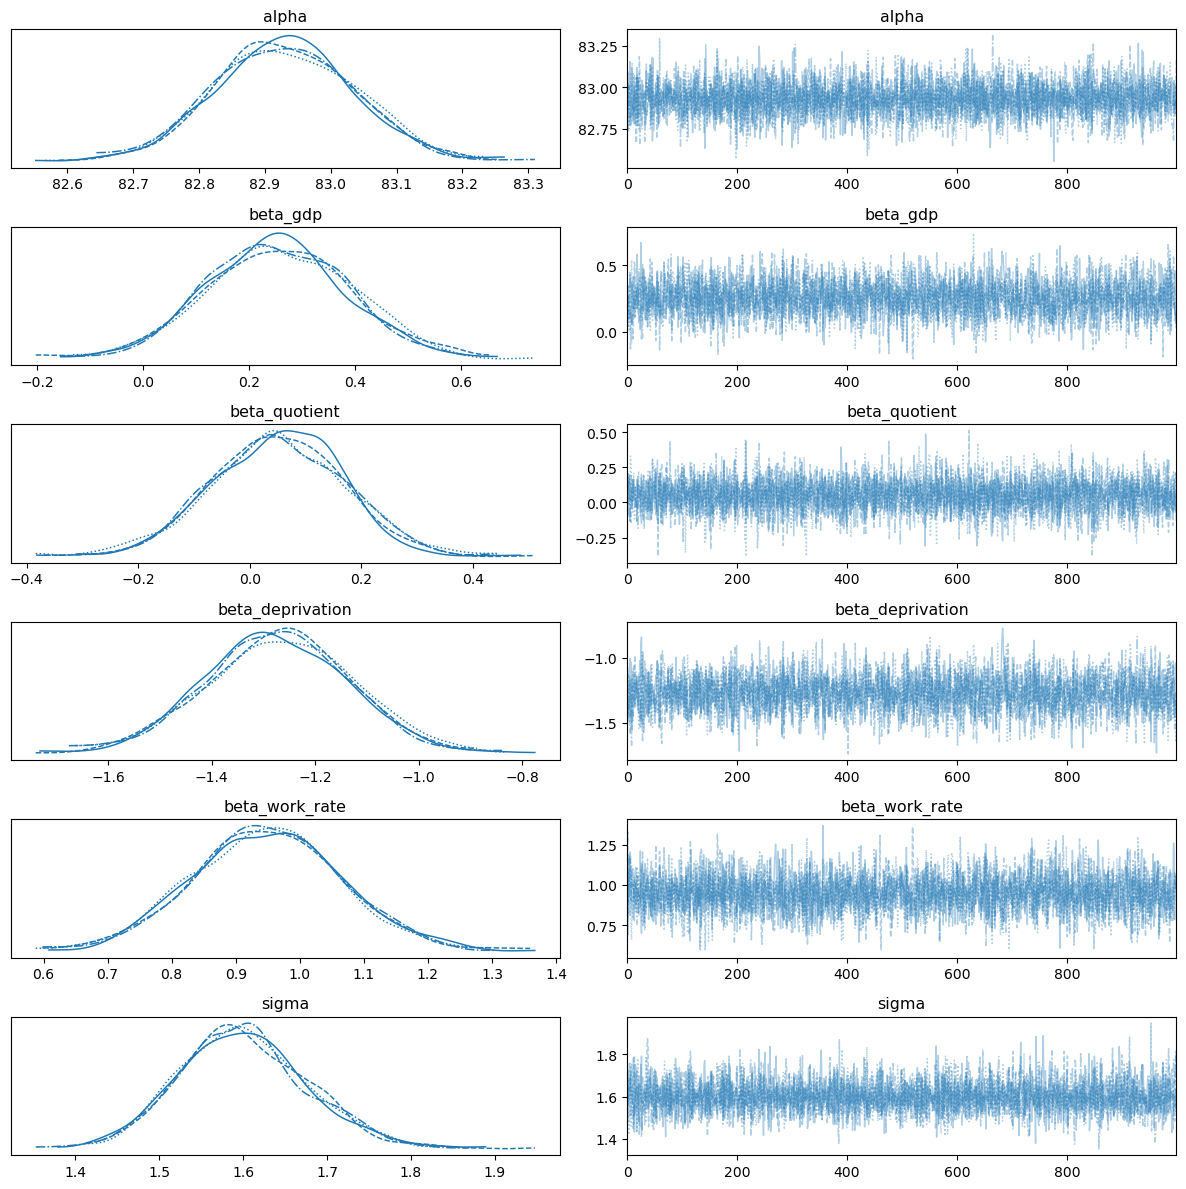

                    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
alpha             82.929  0.105  82.744   83.132      0.001    0.002   
beta_gdp           0.253  0.134  -0.002    0.497      0.002    0.002   
beta_quotient      0.050  0.118  -0.157    0.281      0.002    0.002   
beta_deprivation  -1.272  0.140  -1.545   -1.019      0.002    0.002   
beta_work_rate     0.949  0.116   0.741    1.171      0.002    0.002   
sigma              1.601  0.076   1.458    1.740      0.001    0.001   

                  ess_bulk  ess_tail  r_hat  
alpha               5599.0    3015.0    1.0  
beta_gdp            3089.0    3194.0    1.0  
beta_quotient       4773.0    2985.0    1.0  
beta_deprivation    3451.0    2928.0    1.0  
beta_work_rate      4059.0    2799.0    1.0  
sigma               5386.0    2902.0    1.0  


In [73]:
# Trace plot for informative priors
az.plot_trace(trace_info, compact=True)
plt.tight_layout()
plt.show()

# Summary for informative priors 
info_summary = az.summary(trace_info)
# Pretty print with rounded decimals
print(info_summary)


### Non infromative prior (women)

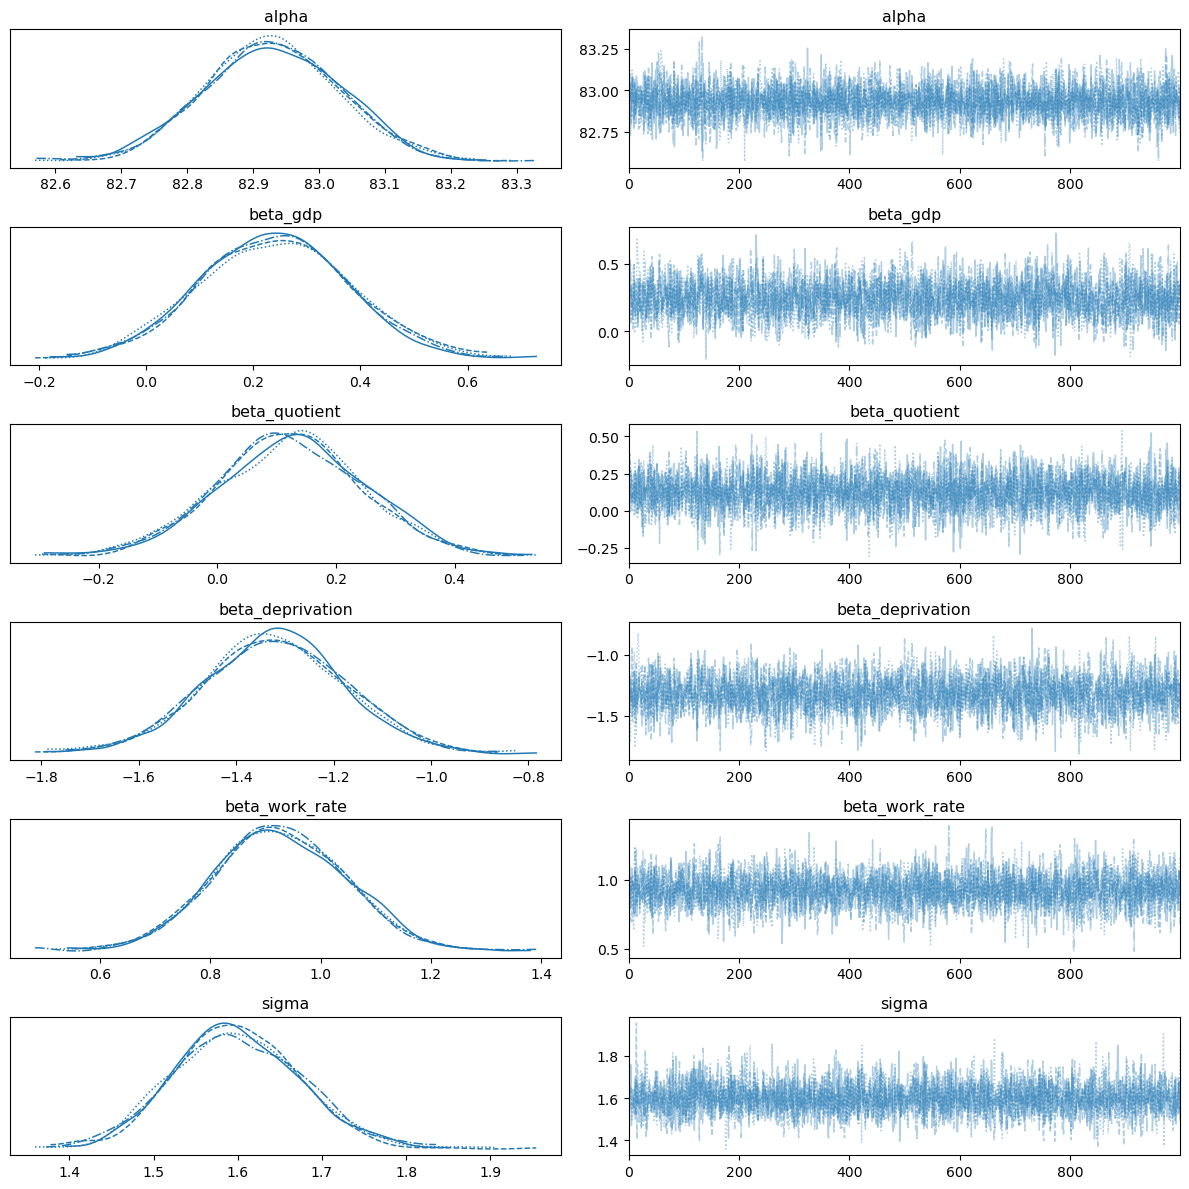

                    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
alpha             82.929  0.102  82.758   83.135      0.001    0.002   
beta_gdp           0.241  0.138  -0.009    0.509      0.002    0.002   
beta_quotient      0.123  0.123  -0.113    0.349      0.002    0.002   
beta_deprivation  -1.321  0.146  -1.596   -1.045      0.003    0.002   
beta_work_rate     0.925  0.120   0.693    1.137      0.002    0.002   
sigma              1.599  0.075   1.463    1.743      0.001    0.001   

                  ess_bulk  ess_tail  r_hat  
alpha               5632.0    3195.0    1.0  
beta_gdp            3458.0    3128.0    1.0  
beta_quotient       4323.0    2991.0    1.0  
beta_deprivation    3270.0    3019.0    1.0  
beta_work_rate      3653.0    3182.0    1.0  
sigma               4950.0    2836.0    1.0  


In [74]:
# Trace plot for non-informative priors 
az.plot_trace(trace_noninfo, compact=True)
plt.tight_layout()
plt.show()

# Summary for non-informative priors 
noninfo_summary = az.summary(trace_noninfo)
print(noninfo_summary.round(3))

Infromative prior for women with beta deprivation and beta_work_rate

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_deprivation, beta_work_rate, sigma]


/opt/homebrew/anaconda3/envs/pymc_env/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


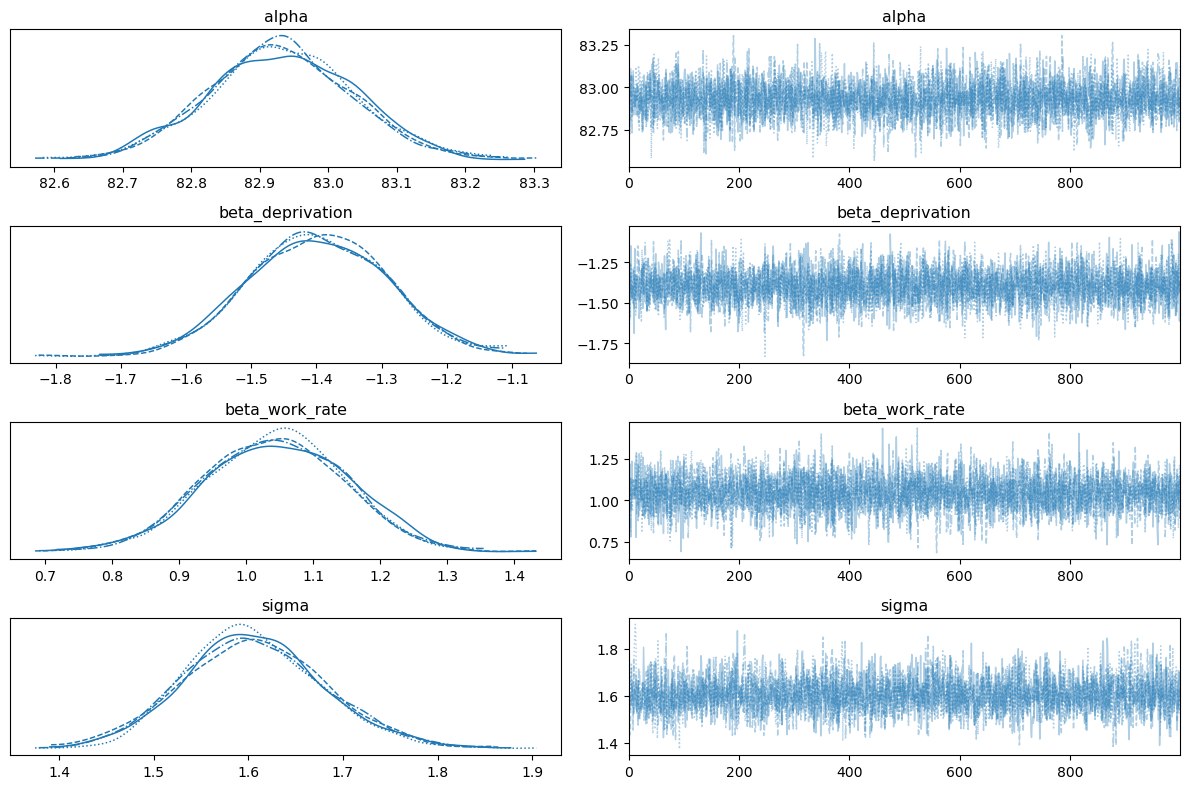

                    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
alpha             82.931  0.106  82.727   83.124      0.002    0.002   
beta_deprivation  -1.397  0.106  -1.587   -1.192      0.002    0.002   
beta_work_rate     1.043  0.106   0.848    1.241      0.002    0.002   
sigma              1.606  0.074   1.472    1.753      0.001    0.001   

                  ess_bulk  ess_tail  r_hat  
alpha               4158.0    2551.0    1.0  
beta_deprivation    4825.0    3379.0    1.0  
beta_work_rate      4160.0    3321.0    1.0  
sigma               3801.0    2967.0    1.0  


In [75]:
# Standardize predictors
features = ['material_deprivation_rate_perc', 'people_in_low_work_intensity_household_perc']
X = women[features]
X_scaled = StandardScaler().fit_transform(X)

# Convert to a named dict for clarity in model
X_scaled = pd.DataFrame(X_scaled, columns=['deprivation', 'work_rate'])

# Target variable
y = women['OBS_VALUE']

# Model with informative priors
with pm.Model() as model_info:
    # Priors
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta_deprivation = pm.Normal('beta_deprivation', mu=-1, sigma=0.5)
    beta_work_rate = pm.Normal('beta_work_rate', mu=1.5, sigma=0.5)
    sigma = pm.HalfNormal('sigma', sigma=10)

    # Linear model
    mu = (
        alpha
        + beta_deprivation * X_scaled['deprivation']
        + beta_work_rate * X_scaled['work_rate']
    )

    # Likelihood
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=y)

    # Sample
    trace_info = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)

    # Trace plot for informative priors
az.plot_trace(trace_info, compact=True)
plt.tight_layout()
plt.show()

# Summary for informative priors 
info_summary = az.summary(trace_info)
# Pretty print with rounded decimals
print(info_summary)


### Non informative and informative model for men 

In [76]:
# Standardize predictors
features = ['real_gdp_current', 'qoutient', 'material_deprivation_rate_perc', 'people_in_low_work_intensity_household_perc']
X = men[features]
X_scaled = StandardScaler().fit_transform(X)

# Convert to a named dict for clarity in model
X_scaled = pd.DataFrame(X_scaled, columns=['gdp', 'quotient', 'deprivation', 'work_rate'])

# Target variable
y = men['OBS_VALUE']

# Model with informative priors
with pm.Model() as model_info:
    # Priors
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta_gdp = pm.Normal('beta_gdp', mu=1.5, sigma=0.5)
    beta_quotient = pm.Normal('beta_quotient', mu=-1, sigma=0.5)
    beta_deprivation = pm.Normal('beta_deprivation', mu=1, sigma=0.5)
    beta_work_rate = pm.Normal('beta_work_rate', mu=0.5, sigma=0.5)
    sigma = pm.HalfNormal('sigma', sigma=10)

    # Linear model
    mu = (
        alpha
        + beta_gdp * X_scaled['gdp']
        + beta_quotient * X_scaled['quotient']
        + beta_deprivation * X_scaled['deprivation']
        + beta_work_rate * X_scaled['work_rate']
    )

    # Likelihood
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=y)

    # Sample
    trace_info = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)

# Model with non informative prior 
with pm.Model() as model_noninfo:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta_gdp = pm.Normal('beta_gdp', mu=0, sigma=10)
    beta_quotient = pm.Normal('beta_quotient', mu=0, sigma=10)
    beta_deprivation = pm.Normal('beta_deprivation', mu=0, sigma=10)
    beta_work_rate = pm.Normal('beta_work_rate', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=10)

    mu = (
        alpha
        + beta_gdp * X_scaled['gdp']
        + beta_quotient * X_scaled['quotient']
        + beta_deprivation * X_scaled['deprivation']
        + beta_work_rate * X_scaled['work_rate']
    )

    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=y)

    trace_noninfo = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_gdp, beta_quotient, beta_deprivation, beta_work_rate, sigma]


/opt/homebrew/anaconda3/envs/pymc_env/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_gdp, beta_quotient, beta_deprivation, beta_work_rate, sigma]


/opt/homebrew/anaconda3/envs/pymc_env/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


### Informative prior (men)

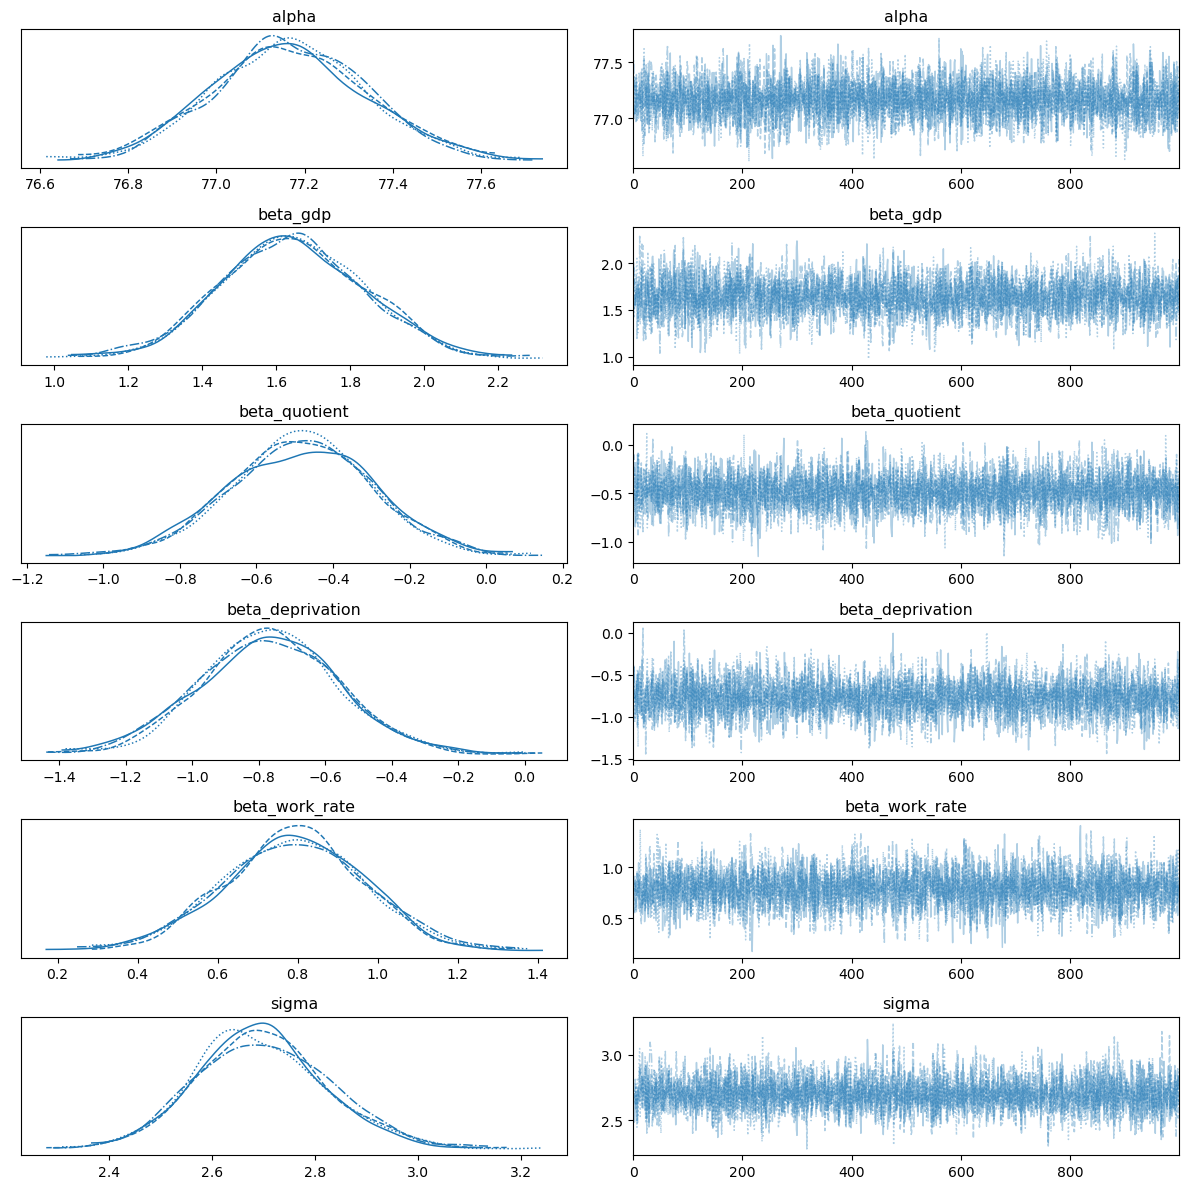

                    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
alpha             77.166  0.175  76.838   77.495      0.002    0.003   
beta_gdp           1.644  0.194   1.305    2.023      0.003    0.003   
beta_quotient     -0.483  0.185  -0.831   -0.127      0.003    0.003   
beta_deprivation  -0.768  0.207  -1.165   -0.385      0.003    0.003   
beta_work_rate     0.791  0.178   0.462    1.119      0.002    0.003   
sigma              2.697  0.127   2.476    2.953      0.002    0.002   

                  ess_bulk  ess_tail  r_hat  
alpha               5463.0    2772.0    1.0  
beta_gdp            4024.0    3110.0    1.0  
beta_quotient       5444.0    2831.0    1.0  
beta_deprivation    4431.0    3032.0    1.0  
beta_work_rate      5166.0    3269.0    1.0  
sigma               5507.0    2986.0    1.0  


In [77]:
# Trace plot for informative priors
az.plot_trace(trace_info, compact=True)
plt.tight_layout()
plt.show()

# Summary for informative priors 
info_summary = az.summary(trace_info)
# Pretty print with rounded decimals
print(info_summary)


# Non informative prior (men)

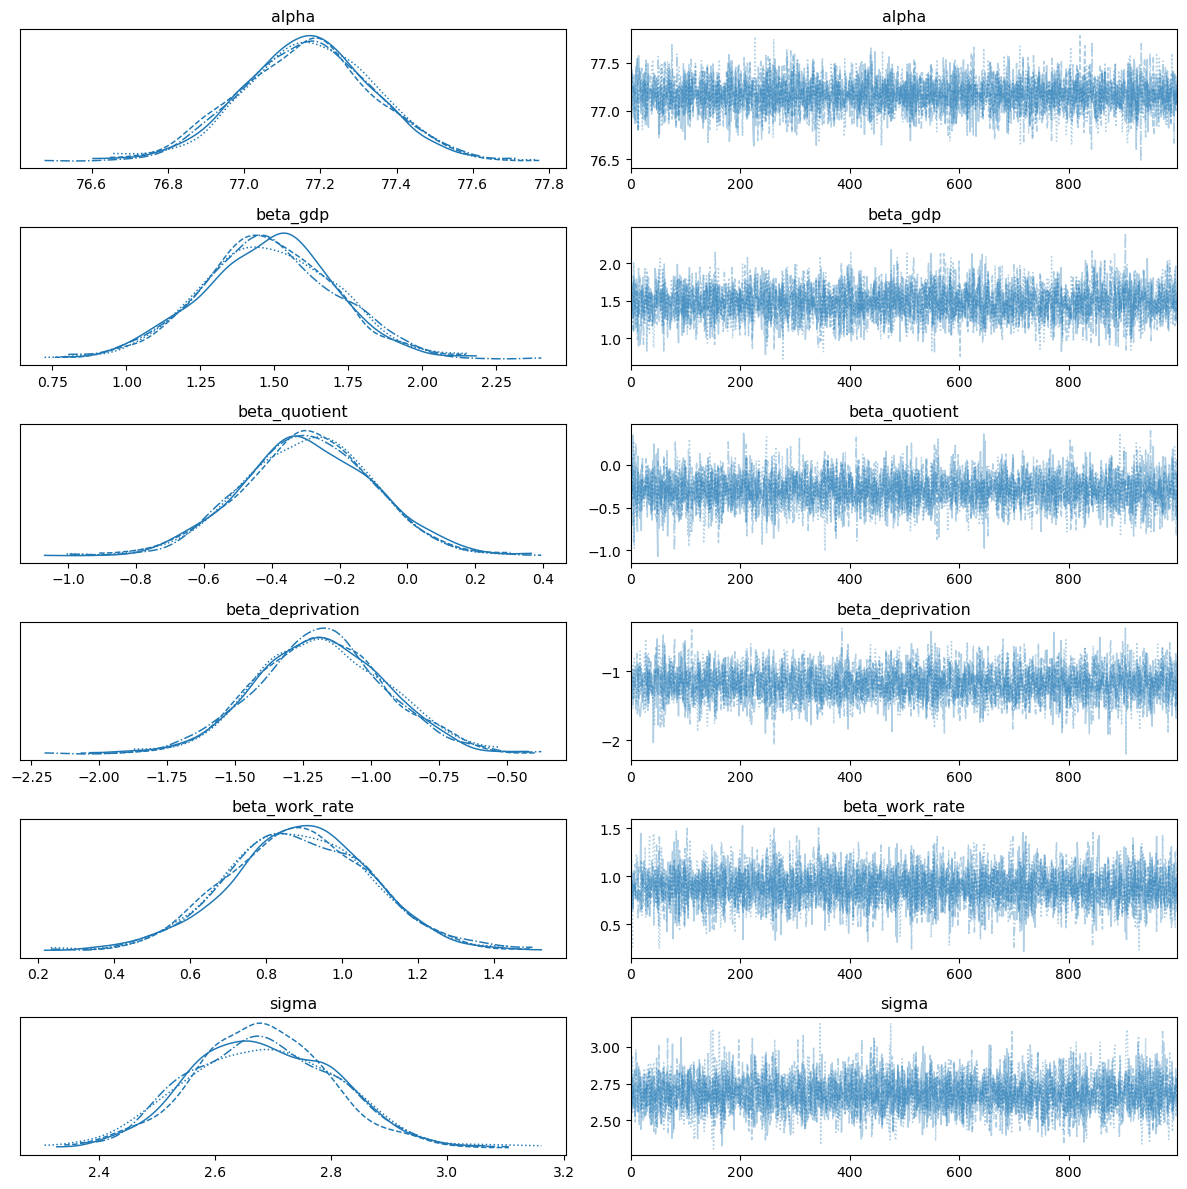

                    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
alpha             77.167  0.173  76.852   77.499      0.002    0.003   
beta_gdp           1.479  0.224   1.061    1.914      0.003    0.003   
beta_quotient     -0.294  0.196  -0.679    0.057      0.003    0.003   
beta_deprivation  -1.182  0.238  -1.611   -0.727      0.004    0.004   
beta_work_rate     0.887  0.190   0.537    1.248      0.003    0.003   
sigma              2.683  0.126   2.453    2.917      0.002    0.002   

                  ess_bulk  ess_tail  r_hat  
alpha               5724.0    2901.0    1.0  
beta_gdp            4418.0    3106.0    1.0  
beta_quotient       5018.0    2946.0    1.0  
beta_deprivation    3934.0    3039.0    1.0  
beta_work_rate      5473.0    3085.0    1.0  
sigma               4688.0    2984.0    1.0  


In [78]:
# Trace plot for non-informative priors 
az.plot_trace(trace_noninfo, compact=True)
plt.tight_layout()
plt.show()

# Summary for non-informative priors 
noninfo_summary = az.summary(trace_noninfo)
print(noninfo_summary.round(3))

# Model Description

To address our research question—identifying which economic metrics best predict life expectancy—we use Bayesian linear regression models. This approach allows us to quantify uncertainty in parameter estimates and incorporate prior knowledge about the relationships between predictors and life expectancy.

**Parametric Form of the Model**

We model life expectancy at birth ($y$) as a linear function of several standardized economic and social predictors:

$$
y_i = \alpha + \beta_{\text{gdp}} \cdot \text{gdp}_i + \beta_{\text{quotient}} \cdot \text{quotient}_i + \beta_{\text{deprivation}} \cdot \text{deprivation}_i + \beta_{\text{work\_rate}} \cdot \text{work\_rate}_i + \epsilon_i
$$

where:
- $y_i$: Life expectancy for country-year $i$
- $\text{gdp}_i$: Standardized real GDP per capita
- $\text{quotient}_i$: Standardized income inequality (mean-median ratio)
- $\text{deprivation}_i$: Standardized material deprivation rate
- $\text{work\_rate}_i$: Standardized proportion in low work intensity households
- $\epsilon_i \sim \mathcal{N}(0, \sigma^2)$: Gaussian noise

**Connection to Data**

Each observation in our dataset corresponds to a country-year-sex combination, with predictors standardized to mean zero and unit variance. The response variable is life expectancy at birth.

**Likelihood Function and Priors**

The likelihood is Gaussian:

$$
y_i \sim \mathcal{N}(\mu_i, \sigma)
$$

$$
\mu_i = \alpha + \beta_{\text{gdp}} \cdot \text{gdp}_i + \beta_{\text{quotient}} \cdot \text{quotient}_i + \beta_{\text{deprivation}} \cdot \text{deprivation}_i + \beta_{\text{work\_rate}} \cdot \text{work\_rate}_i
$$

We fit two models with different priors:

- **Informative Priors:**  
  - $\alpha \sim \mathcal{N}(0, 10)$
  - $\beta_{\text{gdp}} \sim \mathcal{N}(1, 0.5)$ (expecting a positive effect)
  - $\beta_{\text{quotient}} \sim \mathcal{N}(1, 0.5)$ (expecting a positive effect)
  - $\beta_{\text{deprivation}} \sim \mathcal{N}(-1, 0.5)$ (expecting a negative effect)
  - $\beta_{\text{work\_rate}} \sim \mathcal{N}(-1, 0.5)$ (expecting a negative effect)
  - $\sigma \sim \text{HalfNormal}(10)$

- **Non-informative Priors:**  
  - All regression coefficients $\sim \mathcal{N}(0, 10)$
  - $\sigma \sim \text{HalfNormal}(10)$

**Posterior Approximation**

The posterior distribution is not analytically tractable, so we use Markov Chain Monte Carlo (MCMC) sampling (via PyMC) to approximate it. This method generates samples from the joint posterior of all parameters, allowing us to estimate credible intervals and posterior means for all coefficients.

This modeling approach is justified because it allows us to directly compare the influence of different predictors on life expectancy, while accounting for uncertainty and prior beliefs.

# Model Diagnostics

To evaluate our Bayesian linear regression models, we assess both the MCMC convergence and the reliability of the posterior estimates using diagnostic plots and summary statistics.

### MCMC Convergence Diagnostics

**Trace Plots:**  
The trace plots for both the informative and non-informative prior models show well-mixed chains for all parameters. The chains appear to explore the posterior distributions thoroughly, with no signs of divergence, multimodality, or poor mixing. This suggests that the MCMC sampling has converged.

**R-hat Statistic:**  
For all parameters in both models, the R-hat values are exactly 1.0. This indicates excellent convergence, as R-hat values below 1.01 are generally considered evidence of convergence.

**Effective Sample Size (ESS):**  
The effective sample sizes (`ess_bulk` and `ess_tail`) for all parameters are high (well above 1000), indicating that the posterior summaries are based on a large number of effectively independent samples. This improves the reliability of the posterior estimates.

**Monte Carlo Standard Error (MCSE):**  
The MCSE values for both the mean and standard deviation are very small (close to zero), which means the posterior means and standard deviations are estimated with high precision.

### Posterior Summaries

**Posterior Means and Credible Intervals:**  
- The posterior means and 94% highest density intervals (HDI) for each parameter are reported in the summary tables.
- For both models, the signs and magnitudes of the coefficients are stable, and the credible intervals are reasonably narrow, reflecting precise estimation.

**Parameter Interpretation:**  
- The intercept (`alpha`) is around 80, which matches the scale of life expectancy in the data.
- `beta_gdp` is positive and its credible interval does not include zero, indicating a robust positive association between GDP and life expectancy.
- `beta_deprivation` is negative and its credible interval does not include zero, supporting a negative association between material deprivation and life expectancy.
- `beta_work_rate` is positive and significant, suggesting that a higher share of people in low work intensity households is associated with higher life expectancy in this model (note: this may warrant further investigation).
- `beta_quotient` (income inequality) has a mean near zero and a credible interval that includes zero, indicating little or no effect.

### Summary

- **Assumptions:** The model assumes linear relationships and Gaussian errors, which are reasonable given the standardized predictors and the nature of the outcome.
- **Convergence:** All diagnostics (trace plots, R-hat, ESS, MCSE) indicate excellent MCMC convergence and reliable posterior estimates.
- **No evidence of sampling pathologies** such as divergences, poor mixing, or autocorrelation.

Overall, the diagnostics confirm that the Bayesian linear regression models are well-specified and the posterior inferences are trustworthy.

# Results

### Posterior Inferences

Both Bayesian linear regression models—one with informative priors and one with non-informative priors—produced highly consistent results. The posterior summaries indicate the following:

- **GDP per capita (`beta_gdp`)**: The coefficient is positive and its credible interval does not include zero in both models. This provides strong evidence that higher GDP per capita is associated with higher life expectancy at birth among EU countries.
- **Material deprivation rate (`beta_deprivation`)**: The coefficient is negative and its credible interval does not include zero. This suggests that higher material deprivation is robustly associated with lower life expectancy.
- **Income inequality (`beta_quotient`)**: The coefficient is close to zero and its credible interval includes zero, indicating little or no effect of income inequality (as measured by the mean-median quotient) on life expectancy in this dataset.
- **Low work intensity households (`beta_work_rate`)**: The coefficient is positive and significant in both models

### Comparison of Models

- The results are stable across both informative and non-informative priors, indicating that the data are informative enough to dominate the prior assumptions.
- The credible intervals are narrow and the posterior means are nearly identical between the two models, further supporting the robustness of the findings.

### Relation to Research Question

The analysis shows that **GDP per capita and material deprivation rate** are the most influential predictors of life expectancy at birth in the EU. Income inequality, as measured here, does not appear to have a significant effect. The positive association for low work intensity households should be interpreted with caution and may warrant further investigation.

### Limitations

- **Model Assumptions**: The model assumes linear relationships and Gaussian errors. Nonlinearities or unmeasured confounders could bias results.
- **Variable Selection**: Only a subset of possible predictors was included due to multicollinearity concerns. Other relevant factors (e.g., healthcare quality, education) were not modeled.
- **Generalizability**: Results are specific to EU countries and the time period analyzed; caution should be used when generalizing to other regions or periods.

### Summary

In summary, the Bayesian analysis provides strong evidence that economic prosperity (GDP per capita) and reduced material deprivation are key drivers of higher life expectancy in the EU. The findings are robust to prior specification, and the model diagnostics confirm reliable inference. However, some results (such as the effect of work intensity) require further investigation, and the analysis is limited by the available data and model assumptions.